In [ ]:
import numpy as np
import os, tarfile, urllib.request, pickle
import matplotlib.pyplot as plt

# --------------------------------------------------------
# CIFAR-10 LOADING 
# --------------------------------------------------------

CIFAR_URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
CIFAR_TAR = "cifar-10-python.tar.gz"
CIFAR_DIR = "cifar-10-batches-py"

def download_and_extract_cifar10():
    if not os.path.exists(CIFAR_DIR):
        print("Downloading CIFAR-10...")
        urllib.request.urlretrieve(CIFAR_URL, CIFAR_TAR)
        with tarfile.open(CIFAR_TAR, "r:gz") as tar:
            tar.extractall()
        print("CIFAR-10 extracted.")

def load_batch(path):
    with open(path, "rb") as f:
        batch = pickle.load(f, encoding="latin1")
    return batch["data"], np.array(batch["labels"])

def load_cifar10():
    download_and_extract_cifar10()

    xs, ys = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(CIFAR_DIR, f"data_batch_{i}"))
        xs.append(data)
        ys.append(labels)

    X_train = np.concatenate(xs).astype(np.float32) / 255.0  # (50000, 3072)
    y_train = np.concatenate(ys)

    return X_train, y_train


# --------------------------------------------------------
# LABEL CORRUPTION
# --------------------------------------------------------

def corrupt_labels(y, fraction, seed=0):
    rng = np.random.RandomState(seed)
    y_new = y.copy()
    n = len(y)
    k = int(fraction * n)

    idx = rng.choice(n, size=k, replace=False)
    random_labels = rng.randint(0, 10, size=k)

    # ensure wrong labels
    same = random_labels == y_new[idx]
    while np.any(same):
        random_labels[same] = rng.randint(0, 10, size=np.sum(same))
        same = random_labels == y_new[idx]

    y_new[idx] = random_labels
    return y_new


# --------------------------------------------------------
# SIMPLE NUMPY MLP
# --------------------------------------------------------

def one_hot(y, num_classes=10):
    out = np.zeros((y.size, num_classes), np.float32)
    out[np.arange(y.size), y] = 1
    return out

def softmax(z):
    z = z - z.max(1, keepdims=True)
    exp = np.exp(z)
    return exp / exp.sum(1, keepdims=True)

class MLP:
    def __init__(self, input_dim=3072, hidden=256, classes=10):
        rng = np.random.RandomState(0)
        self.W1 = 0.01 * rng.randn(input_dim, hidden).astype(np.float32)
        self.b1 = np.zeros(hidden, np.float32)
        self.W2 = 0.01 * rng.randn(hidden, classes).astype(np.float32)
        self.b2 = np.zeros(classes, np.float32)

    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        h1 = np.maximum(0, z1)
        logits = h1 @ self.W2 + self.b2
        return logits, (X, z1, h1)

    def loss_and_grads(self, X, y):
        logits, (X_, z1, h1) = self.forward(X)
        probs = softmax(logits)
        y_oh = one_hot(y)
        N = X.shape[0]

        loss = -np.sum(y_oh * np.log(probs + 1e-9)) / N

        dlogits = (probs - y_oh) / N
        dW2 = h1.T @ dlogits
        db2 = dlogits.sum(0)

        dh1 = dlogits @ self.W2.T
        dz1 = dh1 * (z1 > 0)

        dW1 = X.T @ dz1
        db1 = dz1.sum(0)

        grads = (dW1, db1, dW2, db2)
        return loss, grads

    def update(self, grads, lr):
        dW1, db1, dW2, db2 = grads
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2


# --------------------------------------------------------
# TRAINING FUNCTION
# --------------------------------------------------------

def train_cifar(noise=0.0, epochs=40, lr=0.1, batch=256):

    X, y_clean = load_cifar10()
    y = corrupt_labels(y_clean, noise) if noise > 0 else y_clean

    model = MLP()
    N = X.shape[0]
    steps = N // batch

    losses = []

    print(f"\n=== Training with {int(noise*100)}% LABEL NOISE ===")

    for ep in range(epochs):
        perm = np.random.permutation(N)
        X, y = X[perm], y[perm]

        epoch_loss = 0
        for i in range(steps):
            xs = X[i*batch:(i+1)*batch]
            ys = y[i*batch:(i+1)*batch]

            loss, grads = model.loss_and_grads(xs, ys)
            model.update(grads, lr)
            epoch_loss += loss

        losses.append(epoch_loss / steps)
        print(f"Epoch {ep+1}/{epochs} : loss = {losses[-1]:.4f}")

    return losses


# --------------------------------------------------------
# RUN BOTH EXPERIMENTS
# --------------------------------------------------------

loss_clean = train_cifar(noise=0.0, epochs=40)
loss_noisy = train_cifar(noise=0.2, epochs=40)

# --------------------------------------------------------
# PLOT 0% vs 20% NOISE
# --------------------------------------------------------

plt.figure(figsize=(7,5))
plt.plot(loss_clean, label="0% noise")
plt.plot(loss_noisy, label="20% noise")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss: 0% vs 20% Label Noise (Pure NumPy)")
plt.legend()
plt.grid(True)
plt.show()


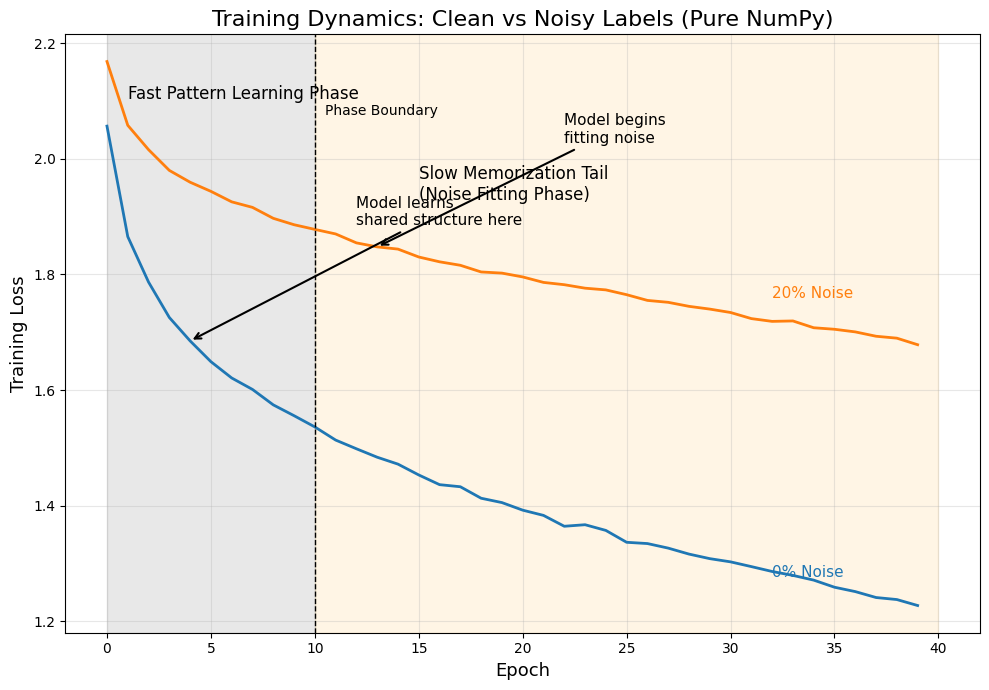

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(len(loss_clean))
phase_boundary = 10

plt.figure(figsize=(10,7))

# Plot curves
plt.plot(epochs, loss_clean, label="0% Noise", linewidth=2, color="#1f77b4")
plt.plot(epochs, loss_noisy, label="20% Noise", linewidth=2, color="#ff7f0e")

# --------------------------
# Shaded regions (no overlap)
# --------------------------
plt.axvspan(0, phase_boundary, color='gray', alpha=0.18)
plt.axvspan(phase_boundary, len(epochs), color='orange', alpha=0.10)

# Vertical boundary line
plt.axvline(phase_boundary, color='black', linestyle='--', linewidth=1)
plt.text(phase_boundary + 0.5,
         max(loss_clean) + 0.02,
         "Phase Boundary",
         fontsize=10)

# --------------------------
# Region labels (fixed positions)
# --------------------------
plt.text(1.0, max(loss_noisy)*0.97,
         "Fast Pattern Learning Phase",
         fontsize=12, color="black")

plt.text(phase_boundary + 5,
         min(loss_noisy) + 0.25,
         "Slow Memorization Tail\n(Noise Fitting Phase)",
         fontsize=12, color="black")

# --------------------------
# Arrow annotations (repositioned)
# --------------------------
# Arrow 1 (clean curve)
plt.annotate("Model learns\nshared structure here",
             xy=(4, loss_clean[4]),
             xytext=(12, loss_clean[4] + 0.20),
             fontsize=11,
             arrowprops=dict(arrowstyle="->", lw=1.5, color="black"))

# Arrow 2 (noisy curve)
plt.annotate("Model begins\nfitting noise",
             xy=(phase_boundary + 3, loss_noisy[phase_boundary + 3]),
             xytext=(phase_boundary + 12, loss_noisy[phase_boundary + 3] + 0.18),
             fontsize=11,
             arrowprops=dict(arrowstyle="->", lw=1.5, color="black"))

# --------------------------
# Curve labels 
# --------------------------
plt.text(len(epochs) - 8,
         loss_clean[-1] + 0.05,
         "0% Noise", color="#1f77b4", fontsize=11)

plt.text(len(epochs) - 8,
         loss_noisy[-1] + 0.08,
         "20% Noise", color="#ff7f0e", fontsize=11)

# --------------------------
# Formatting
# --------------------------
plt.title("Training Dynamics: Clean vs Noisy Labels (Pure NumPy)", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Training Loss", fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()
